In [11]:

from ipywidgets import *
import torch
import torch.fft as fft
import torch.nn.functional as F
from torch import nn
from einops import rearrange
from einops.layers.torch import Rearrange
import numpy as np
import math
import h5py
import matplotlib.pyplot as plt
from pathlib import Path
# import dataset and dataloader pytroch
from torch.utils.data import Dataset, DataLoader, Sampler, Subset
import netCDF4 as nc
import yaml
import os


#### TODO Overall
- Check resample line profiling
- Extend Datasets with normalisation
- Add PE to model + dropout
- Zero shot training
- Add physics statistics
- clean up framework/split yaml configs
- Train model on single dataset?
- Add checkpointing for SPIKE-1
- Pytorch Lightning/Distributed training
- https://catalog.ngc.nvidia.com/orgs/nvidia/containers/pytorch

Short term:
- Implement normalisation and down/upscaling on spatial and temporal axis datasets -> implement dataloaders in code
- Split config file structure (single file -> model architecture/dataset/training protocol split)
- Enable and test distributed training (Pytorch Lightning?)
- Test out current swinUnet model architecture hyperparam (single step) on snellius
- Try out Windows-built docker image on Linux workstation


Down the road:
- Add checkpointing to code for overquota use on DGX B-200
- Temporal bundling/forward temporal attention layer
- Pushforward trick on transformers?
- Find faster base image for docker
- Clean Github repo and change name

In [8]:
x = torch.randn(10, 21, 128,128)
x[1:6:2].shape

torch.Size([3, 21, 128, 128])

In [12]:
class PDEGymDataset(Dataset):
    def __init__(self, filepaths, resample_shape=128, resample_mode='fourier', timesample=1, forward_steps=1):

        self.data_list = []
        self.resample_shape = resample_shape
        self.resample_mode = resample_mode
        self.name = None
        self.vel_scale = None
        self.dt = timesample
        self.fs = forward_steps
        
        for filepath in filepaths:
            with nc.Dataset(filepath, "r") as f:
                data = torch.from_numpy(f['velocity'][:,:,:2])  # remove passive tracer
                data = spatial_resample(data, self.resample_shape, self.resample_mode)
                self.data_list.append(data)  

        self.data = torch.cat(self.data_list, dim=0) 
        self.traj = self.data.shape[0]
        self.ts = self.data.shape[1]
        #print(self.ts)

    def __len__(self):
        return self.traj * (self.ts - self.dt * self.fs)

    def __getitem__(self, idx):
        traj_idx = idx // (self.ts - self.dt * self.fs)
        ts_idx = idx % (self.ts - self.dt * self.fs)

        #front = self.data[traj_idx][ts_idx : ts_idx + self.fs * self.dt + 1 : self.dt]
        #label = self.data[traj_idx][ts_idx : ts_idx + self.fs * self.dt + 1 : self.dt]
        front = self.data[traj_idx][ts_idx]
        label = self.data[traj_idx][ts_idx + self.fs * self.dt]
        #front = spatial_resample(front, self.resample_shape, self.resample_mode)
        #label = spatial_resample(label, self.resample_shape, self.resample_mode)
        return front, label #front.unsqueeze(0), label.unsqueeze(0)
        
    def get_single_traj(self, idx):
        full = self.data[idx][::self.dt]
        #full = spatial_resample(full, self.resample_shape, self.resample_mode)
        return full
    
    def normalize_velocity(self, vel_scale):
        self.data = self.data / vel_scale
        self.vel_scale = vel_scale

    def absmax_vel(self):
        return self.data.abs().max()

class ZeroShotSampler(Sampler):
    def __init__(self, dataset, train_ratio=0.8, split="train", seed=227, n=1):
        torch.manual_seed(seed) 
        num_train = int(dataset.traj * train_ratio)
        shuffled_trajs = torch.randperm(dataset.traj).tolist() 
        train_trajs = shuffled_trajs[:num_train]
        self.val_trajs = shuffled_trajs[num_train:]
        train_indices = [t * (dataset.ts - dataset.dt) + ts for t in train_trajs for ts in range(dataset.ts - dataset.dt * n)]
        val_indices = [t * (dataset.ts - dataset.dt) + ts for t in self.val_trajs for ts in range(dataset.ts - dataset.dt * n)]
        self.indices = train_indices if split == "train" else val_indices
    def __iter__(self):
        return iter(self.indices)
    def __len__(self):
        return len(self.indices)
    def random_val_traj(self):
        return self.val_trajs[torch.randint(0, len(self.val_trajs), (1,)).item()]
  

In [13]:
from dataloaders.utils import spatial_resample, get_dataset

dataset = get_dataset(PDEGymDataset, '../datasets/prjs1359/PDEGym-NSGauss', 'nc', resample_shape=32, resample_mode='fourier', timesample=1, n=1)
dataset2 = get_dataset(PDEGymDataset, '../datasets/prjs1359/PDEGym-NSGauss', 'nc', resample_shape=32, resample_mode='fourier', timesample=1, n=5)

In [28]:
....

SyntaxError: invalid syntax (1805539695.py, line 1)

In [14]:
dataset.data.shape
dataset.data = dataset.data[:10]
dataset2.data = dataset2.data[:10]
dataset.data.shape
dataset.traj = 10
dataset2.traj = 10

In [15]:

train_sampler = ZeroShotSampler(dataset, train_ratio=0.8, split="train")
val_sampler = ZeroShotSampler(dataset, train_ratio=0.8, split="val")

#train_set = Subset(dataset, train_sampler.indices)
#val_set = Subset(dataset, val_sampler.indices)
print(train_sampler.val_trajs, val_sampler.val_trajs)
for i in val_sampler:
    print(i, end=' ')
print()
print(len(val_sampler))

train_sampler = ZeroShotSampler(dataset, train_ratio=0.8, split="train", n=5)
val_sampler = ZeroShotSampler(dataset, train_ratio=0.8, split="val", n=5)

#train_set = Subset(dataset, train_sampler.indices)
#val_set = Subset(dataset, val_sampler.indices)
print(train_sampler.val_trajs, val_sampler.val_trajs)
for i in val_sampler:
    print(i, end=' ')
print()
print(len(val_sampler))

[7, 9] [7, 9]
140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 
40
[7, 9] [7, 9]
140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 
32


torch.Size([1, 2, 32, 32]) torch.Size([1, 2, 32, 32])
torch.Size([1, 2, 32, 32]) torch.Size([1, 2, 32, 32])
torch.Size([1, 2, 32, 32]) torch.Size([1, 2, 32, 32])
torch.Size([1, 2, 32, 32]) torch.Size([1, 2, 32, 32])
torch.Size([1, 2, 32, 32]) torch.Size([1, 2, 32, 32])
torch.Size([1, 2, 32, 32]) torch.Size([1, 2, 32, 32])
torch.Size([1, 2, 32, 32]) torch.Size([1, 2, 32, 32])
torch.Size([1, 2, 32, 32]) torch.Size([1, 2, 32, 32])
torch.Size([1, 2, 32, 32]) torch.Size([1, 2, 32, 32])
torch.Size([1, 2, 32, 32]) torch.Size([1, 2, 32, 32])
torch.Size([1, 2, 32, 32]) torch.Size([1, 2, 32, 32])
torch.Size([1, 2, 32, 32]) torch.Size([1, 2, 32, 32])
torch.Size([1, 2, 32, 32]) torch.Size([1, 2, 32, 32])
torch.Size([1, 2, 32, 32]) torch.Size([1, 2, 32, 32])
torch.Size([1, 2, 32, 32]) torch.Size([1, 2, 32, 32])
torch.Size([1, 2, 32, 32]) torch.Size([1, 2, 32, 32])
torch.Size([1, 2, 32, 32]) torch.Size([1, 2, 32, 32])
torch.Size([1, 2, 32, 32]) torch.Size([1, 2, 32, 32])
torch.Size([1, 2, 32, 32]) t

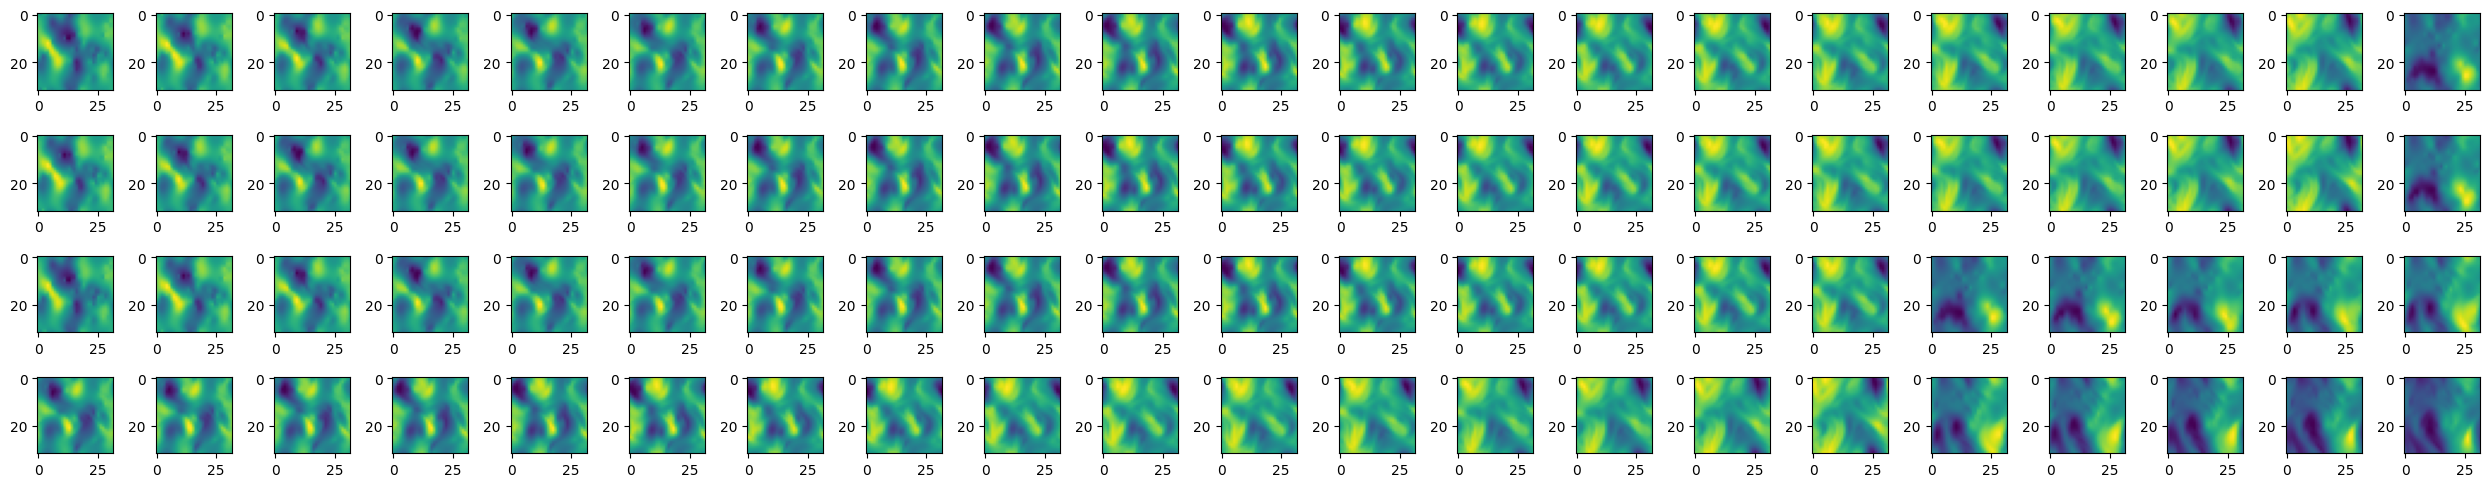

In [18]:
loader = DataLoader(dataset, batch_size=1)
loader2 = DataLoader(dataset2, batch_size=1)
fig, ax = plt.subplots(4,21, figsize=(25,5))
i = 0
for x, y in loader:
    print(x.shape, y.shape)
    x = x.squeeze()
    y = y.squeeze()
    #print(x.shape)
    ax[0,i].imshow(x[0])
    ax[1,i].imshow(y[0])
    i += 1
    if i==21:
        break
i = 0

for x, y in loader2:
    x = x.squeeze()
    y = y.squeeze()
    ax[2,i].imshow(x[0])
    ax[3,i].imshow(y[0])
    #print(x.shape)
    i += 1
    #break
    if i==21:
        break
plt.tight_layout()
plt.show()

In [73]:
def bicubic_resample(data, target_shape, device):
    assert data.dim() >= 2, "Input must have at least 2 dimensions"
    assert data.shape[-2] == data.shape[-1], 'Only square images supported'
    assert target_shape[0] == target_shape[1], 'Only square output images supported'
    assert data.shape[-2] != target_shape[0], 'Image already in target shape'
    
    original_shape = data.shape
    flattened = data.reshape(-1, *original_shape[-2:]).to(device)
    
    if flattened.dim() == 2:
        flattened = flattened.unsqueeze(0).unsqueeze(0) 
    elif flattened.dim() == 3:
        flattened = flattened.unsqueeze(1) 
    
    resampled = torch.nn.functional.interpolate(
        flattened, 
        size=target_shape, 
        mode='bicubic', 
        align_corners=False
    )
    
    if data.dim() == 2:
        resampled = resampled.squeeze(0).squeeze(0)
    elif data.dim() == 3:
        resampled = resampled.squeeze(1)
    else:
        resampled = resampled.reshape(*original_shape[:-2], *target_shape)
    
    return resampled

def fourier_resample(data, target_shape, device):
    assert data.dim() >= 2, "Input must have at least 2 dimensions"
    
    original_shape = data.shape
    x, y = data.shape[-2], data.shape[-1]
    target_x, target_y = target_shape
    assert x == y, 'Only square images supported'
    assert target_x == target_y, 'Only square images supported'

    #device = data.device
    flattened = data.reshape(-1, x, y)
    signal = flattened.to(dtype=torch.complex64, device=device)

    pos0 = torch.linspace(0.5, x - 0.5, x, device=device)
    pos1 = torch.linspace(0.5, target_x - 0.5, target_x, device=device)
    freq0 = torch.fft.fftfreq(x, device=device)
    freq1 = torch.fft.fftfreq(target_x, device=device)

    exp_matrix_0 = torch.exp(-2j * torch.pi * torch.outer(pos0, freq0))
    exp_matrix_1 = torch.exp(2j * torch.pi * torch.outer(freq1, pos1))

    results = []
    for item in signal:
        freq_coeff = torch.matmul(torch.matmul(exp_matrix_0.H, item), exp_matrix_0) / x**2
        scaled_coeff = torch.zeros((target_x, target_x), dtype=torch.complex64, device=device)

        if target_x > x:  # Upsample
            min_idx = (target_x - x) // 2
            scaled_coeff[min_idx:min_idx + x, min_idx:min_idx + x] = torch.fft.fftshift(freq_coeff)
            scaled_coeff = torch.fft.ifftshift(scaled_coeff)
        else:  # Downsample
            min_idx = (x - target_x) // 2
            scaled_coeff = torch.fft.fftshift(freq_coeff)[min_idx:min_idx + target_x, min_idx:min_idx + target_x]
            scaled_coeff = torch.fft.ifftshift(scaled_coeff)

        scaled_signal = torch.matmul(torch.matmul(exp_matrix_1.H, scaled_coeff), exp_matrix_1)
        results.append(scaled_signal.real)

    output = torch.stack(results).reshape(*original_shape[:-2], target_x, target_y)
    return output


def spatial_resample(data, target_shape, mode):
    if data.shape[-1] == target_shape and data.shape[-2] == target_shape:
        return data
    old_device = data.device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if mode == 'bicubic':
        return bicubic_resample(data, (target_shape, target_shape), device).to(old_device)
    elif mode == 'fourier':
        return fourier_resample(data, (target_shape, target_shape), device).to(old_device)
    else:
        raise ValueError(f'Unknown mode: {mode}')

In [80]:
x = torch.randn(1,2,2,512,512)
for i in range(5000):
    y = bicubic_resample(x, target_shape=(128,128), device=torch.device('cuda'))#, device=torch.device('cuda'))
print(x.device)


cpu


In [81]:
x = torch.randn(1,2,2,512,512)
for i in range(5000):
    y = bicubic_resample(x, target_shape=(128,128), device=torch.device('cpu'))#, device=torch.device('cuda'))
print(x.device)


cpu


In [87]:
x = torch.randn(1,2,2,512,512)
x.to(torch.device('cuda'))
for i in range(5000):
    y = bicubic_resample(x, target_shape=(128,128), device=torch.device('cuda'))#, device=torch.device('cuda'))
print(x.device)


cpu


In [82]:
x = torch.randn(1,2,2,512,512)
#x = x.to(torch.device('cuda'))
for i in range(5000):
    y = fourier_resample(x, target_shape=(128,128), device=torch.device('cuda'))#, device=torch.device('cuda'))
print(x.device)


cpu


In [85]:
x = torch.randn(1,2,2,512,512)
for i in range(100):
    y = fourier_resample(x, target_shape=(128,128), device=torch.device('cpu'))#, device=torch.device('cuda'))
print(x.device)
7.1 * 50

cpu


355.0

In [86]:
x = torch.randn(1,2,2,512,512)
x.to(torch.device('cuda'))
for i in range(5000):
    y = fourier_resample(x, target_shape=(128,128), device=torch.device('cuda'))#, device=torch.device('cuda'))
print(x.device)

cpu


In [2]:
from dataloaders.utils import spatial_resample, get_dataset
from dataloaders.PDEBenchIncompDataset import PDEBenchIncompDataset
from dataloaders.AmiraDatasetFromAM import AmiraDatasetFromAM
#dataset = get_dataset(PDEBenchIncompDataset, '../datasets/prjs1359/PDEBench-Incomp/','h5', resample_shape=(256,256), resample_mode='fourier', timesample=10)
dataset = get_dataset(AmiraDatasetFromAM, '../datasets/prjs1359/AmiraSet/', 'am', resample_shape=128, resample_mode='fourier', timesample=5)
dataset.name = 'test123'
loader = DataLoader(dataset, batch_size=5, shuffle=False)
for x, y in loader:
    print(x.shape, y.shape)
    break


torch.Size([5, 2, 128, 128]) torch.Size([5, 2, 128, 128])


In [3]:
loader = DataLoader(dataset, batch_size=5, shuffle=False)
for x, y in loader:
    print(x.shape, y.shape)
    break
print(len(loader))

torch.Size([5, 2, 128, 128]) torch.Size([5, 2, 128, 128])
996


In [3]:
loader = DataLoader(dataset, batch_size=1, shuffle=False)
for x, y in loader:
    print(x.shape, y.shape)
    break
print(len(loader))

torch.Size([1, 2, 128, 128]) torch.Size([1, 2, 128, 128])
4980


In [6]:
from torch.utils.data import Sampler, Subset
import matplotlib.animation as animation

class ZeroShotSampler(Sampler):
    def __init__(self, dataset, train_ratio=0.8, split="train", seed=227):
        torch.manual_seed(seed) 
        num_train = int(dataset.traj * train_ratio)
        shuffled_trajs = torch.randperm(dataset.traj).tolist() 
        train_trajs = shuffled_trajs[:num_train]
        self.val_trajs = shuffled_trajs[num_train:]
        train_indices = [t * (dataset.ts - dataset.dt) + ts for t in train_trajs for ts in range(dataset.ts - dataset.dt)]
        val_indices = [t * (dataset.ts - dataset.dt) + ts for t in self.val_trajs for ts in range(dataset.ts - dataset.dt)]
        self.indices = train_indices if split == "train" else val_indices
    def __iter__(self):
        return iter(self.indices)
    def __len__(self):
        return len(self.indices)
    def random_val_traj(self):
        return self.val_trajs[torch.randint(0, len(self.val_trajs), (1,)).item()]
    
train_ratio = 0.5

train_sampler = ZeroShotSampler(dataset, train_ratio=train_ratio, split="train")
val_sampler = ZeroShotSampler(dataset, train_ratio=train_ratio, split="val")

train_loader = DataLoader(dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=16, sampler=val_sampler)

val = val_sampler.random_val_traj()
#print(val)
val_traj = dataset.get_single_traj(val)
print(val_traj.shape)
front = val_traj[0].unsqueeze(0)	
print(front.shape)

def model(x):
    return x
def magnitude_vel(x):
    magnitude = torch.sqrt(x[:, 0]**2 + x[:, 1]**2)
    return magnitude.unsqueeze(1)

def rollout(x, length):
    # model eval
    preds = []
    with torch.no_grad():
        pred = model(front)
        preds.append(pred)
        for i in range(length - 1):
            pred = model(pred)
            preds.append(pred)
    preds = torch.cat(preds, dim=0)
    return preds

preds = rollout(front, len(val_traj))
print(preds.shape)
preds = magnitude_vel(preds)
val_mag = magnitude_vel(val_traj)


torch.Size([201, 2, 128, 128])
torch.Size([1, 2, 128, 128])
torch.Size([201, 2, 128, 128])


In [ ]:

def animate_rollout(stacked_pred, stacked_true, output_path="../output/rollout.gif"):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    timesteps, _, x_dim, y_dim = stacked_pred.shape
    stacked_pred, stacked_true = stacked_pred.squeeze(1).cpu().numpy(), stacked_true.squeeze(1).cpu().numpy()
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    titles = ["Pred", "True"]
    imgs = []
    vmin, vmax = min(stacked_pred.min(), stacked_true.min()), max(stacked_pred.max(), stacked_true.max())

    for ax, title in zip(axes, titles):
        img = ax.imshow(np.zeros((x_dim, y_dim)), cmap='viridis', vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
        imgs.append(img)
    
    def init():
        imgs[0].set_data(stacked_pred[0])
        imgs[1].set_data(stacked_true[0])
        return imgs

    def update(frame):
        imgs[0].set_data(stacked_pred[frame])
        imgs[1].set_data(stacked_true[frame])

        fig.suptitle(f"Dataset: {dataset.name}, timestep {frame + 1}")
        return imgs

    ani = animation.FuncAnimation(fig, update, frames=timesteps, init_func=init, blit=False, interval=50)
    ani.save(output_path, writer="ffmpeg")
    plt.close()
animate_rollout(preds, val_mag, output_path="../output/lala123.gif")

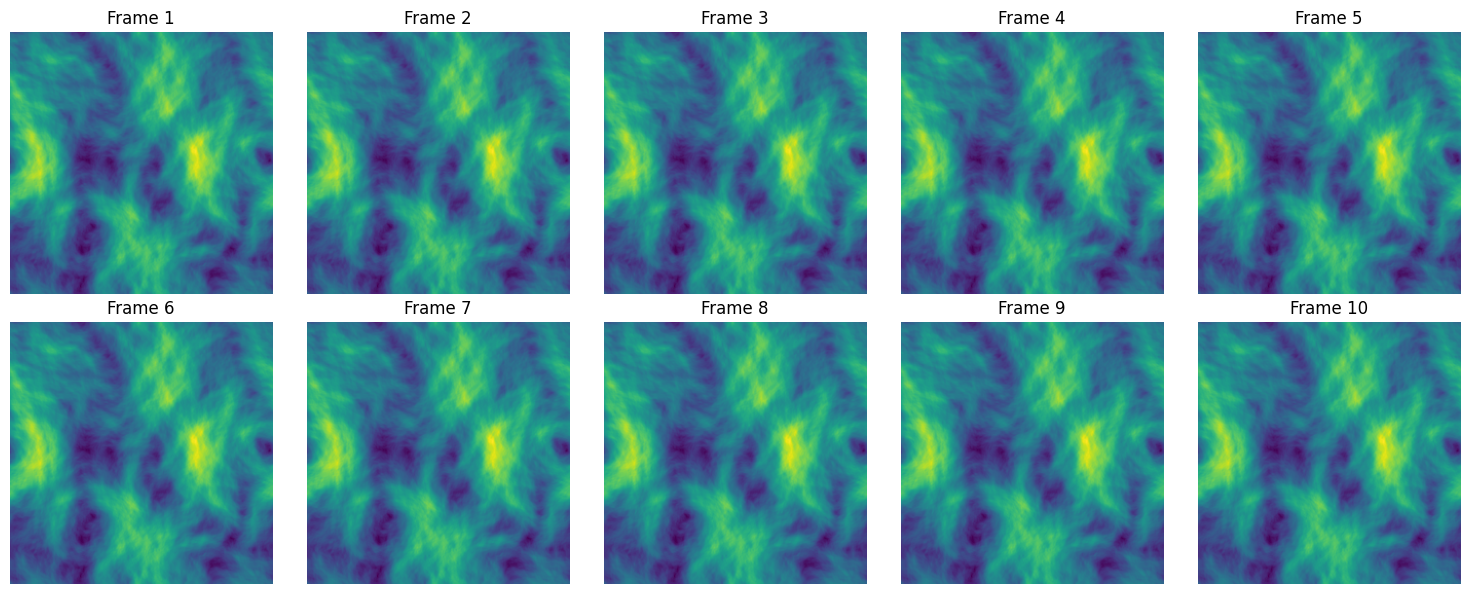

In [5]:
# plot the first 10 frames of preds
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(preds[i].squeeze(0).cpu().numpy(), cmap='viridis')
    ax.set_title(f"Frame {i + 1}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
....

SyntaxError: invalid syntax (1805539695.py, line 1)

In [13]:
train_sampler = ZeroShotSampler(dataset, train_ratio=train_ratio, split="train")
val_sampler = ZeroShotSampler(dataset, train_ratio=train_ratio, split="val")

train_dataset = Subset(dataset, train_sampler.indices)
val_dataset = Subset(dataset, val_sampler.indices)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
for idx, (x, y) in enumerate(train_loader):
    #print(x.shape, y.shape)
    print(idx * 16)
for idx, (x, y) in enumerate(val_loader):
    #print(x.shape, y.shape)
    print(idx * 16)


0
16
32
48
64
80
96
112
128
144
160
176
192
208
224
240
256
272
288
304
320
336
352
368
384
400
416
432
448
464
480
496
512
528
544
560
576
592
0
16
32
48
64
80
96
112
128
144
160
176
192


In [ ]:
from src.dataloaders.utils import spatial_resample, get_dataset
from src.dataloaders.AmiraLoaderFromH5 import AmiraDatasetFromH5

def get_dataset(dataset_obj, folderPath, file_ext, resample_shape, resample_mode, timesample):
    subdir = Path(folderPath)
    print(subdir)
    assert subdir.exists(), 'doesnt exist homie'
    files = list(subdir.glob("*." + str(file_ext)))
    return dataset_obj(files, resample_shape, resample_mode, timesample)

#dataset = AmiraDatasetFromH5(filepaths, resample_shape=(256, 256), resample_mode='fourier')
dataset = get_dataset(AmiraDatasetFromH5, 'data/prjs1359/AmiraSet/','h5', resample_shape=(256,256), resample_mode='fourier', timesample=5)
loader = DataLoader(dataset, batch_size=5, shuffle=False)
for x, y in loader:
    print(x.shape, y.shape)
    #break

In [ ]:
from src.dataloaders.utils import get_dataset
from src.dataloaders.PDEBenchIncompLoader import PDEBenchIncompDataset

def get_dataset(dataset_obj, folderPath, file_ext, resample_shape, resample_mode, timesample):
    subdir = Path(folderPath)
    print(subdir)
    assert subdir.exists(), 'doesnt exist homie'
    files = list(subdir.glob("*." + str(file_ext)))
    return dataset_obj(files, resample_shape, resample_mode, timesample)

#dataset = AmiraDatasetFromH5(filepaths, resample_shape=(256, 256), resample_mode='fourier')
dataset = get_dataset(PDEBenchIncompDataset, 'data/prjs1359/PDEBench-Incomp/','h5', resample_shape=(256,256), resample_mode='fourier', timesample=5)
loader = DataLoader(dataset, batch_size=5, shuffle=False)
for x, y in loader:
    print(x.shape, y.shape)
    #break

In [ ]:
from src.dataloaders import *
from src.dataloaders.utils import get_dataset
from torch.utils.data import ConcatDataset

filepath0 = 'conf/base/std.yaml'
filepath1 = 'conf/data/test.yaml'

DATASET_MAPPER = {"AmiraDatasetFromAM": AmiraDatasetFromAM,
                  "PDEBenchIncompDataset": PDEBenchIncompDataset}

with open(filepath0, "r") as file:
    config0 = yaml.safe_load(file)
with open(filepath1, "r") as file:
    config1 = yaml.safe_load(file)
for item in config0:
    print(item)
print(config0["data_path"])
for item in config1['datasets']:
    print(item)
print()
datalist = []
for item in config1['datasets']:
    datalist.append(get_dataset(dataset_obj = DATASET_MAPPER[item["dataset"]], 
                                folderPath = str(config0["data_path"] + item["path"]), 
                                file_ext = item["file_ext"], 
                                resample_shape = item["resample_shape"], 
                                resample_mode = item["resample_mode"], 
                                timesample = item["timesample"])
    )

data_path
device
save_path
save_on
wandb
wandb_name
datasets/prjs1359/
{'name': 'amira', 'path': 'AmiraSet/', 'dataset': 'AmiraDatasetFromAM', 'file_ext': 'am', 'resample_shape': [256, 256], 'resample_mode': 'fourier', 'timesample': 5}
{'name': 'pdebench_incomp', 'path': 'PDEBench-Incomp/', 'dataset': 'PDEBenchIncompDataset', 'file_ext': 'h5', 'resample_shape': [256, 256], 'resample_mode': 'fourier', 'timesample': 10}

[PosixPath('datasets/prjs1359/AmiraSet/7999.am'), PosixPath('datasets/prjs1359/AmiraSet/6999.am')]
datasets/prjs1359/AmiraSet/7999.am
datasets/prjs1359/AmiraSet/6999.am
[PosixPath('datasets/prjs1359/PDEBench-Incomp/ns_incom_inhom_2d_512-100.h5'), PosixPath('datasets/prjs1359/PDEBench-Incomp/ns_incom_inhom_2d_512-0.h5')]
8
100


In [ ]:

class PDEBenchCompDataset(Dataset):
    def __init__(self, filepaths, resample_shape=(256, 256), resample_mode='fourier', timesample=1):
        self.data_list = []
        self.traj_list = []
        self.ts = None
        self.resample_shape = resample_shape
        self.resample_mode = resample_mode

        for filepath in filepaths:
            with h5py.File(filepath, "r") as f:
                keys = list(f.keys())
                print(f"Keys in {filepath}: {keys}")
                
                if "Vx" in keys and "Vy" in keys:
                    
                    data = torch.from_numpy(
                        np.stack((f["Vx"][:,::timesample], f["Vy"][:,::timesample]), axis=2).astype(np.float32)
                    )

                    if self.ts is None:
                        self.ts = data.shape[1]
                    elif self.ts != data.shape[1]:
                        raise ValueError("Mismatch in timestep dimensions across files.")
                    
                    self.data_list.append(data)
                    self.traj_list.append(data.shape[0])
        
        self.data = torch.cat(self.data_list, dim=0)
        self.traj = sum(self.traj_list)
        
    def __len__(self):
        return self.traj * (self.ts - 1)

    def __getitem__(self, idx):
        traj_idx = idx // (self.ts - 1)
        ts_idx = idx % (self.ts - 1)
        front = self.data[traj_idx][ts_idx]
        label = self.data[traj_idx][ts_idx + 1]
        front = spatial_resample(front, self.resample_shape, mode=self.resample_mode)
        label = spatial_resample(label, self.resample_shape, mode=self.resample_mode)
        return front.unsqueeze(0), label.unsqueeze(0)

filenames = ['2D_CFD_Rand_M0.1_Eta0.01_Zeta0.01_periodic_128_Train.hdf5']#, '2D_CFD_Rand_M1.0_Eta0.01_Zeta0.01_periodic_128_Train.hdf5']
filebase = 'data/prjs1359/PDEBench-Comp/'
filepaths = [filebase + filename for filename in filenames]
dataset = PDEBenchCompDataset(filepaths)


In [ ]:
dataset.ts

In [ ]:
from src.dataloaders.utils import spatial_resample
loader = DataLoader(dataset, batch_size=8, shuffle=False)
for x, y in loader:
    print(x.shape, y.shape)
    break

In [ ]:

from src.dataloaders.utils import spatial_resample, get_dataset
from src.dataloaders.AmiraLoaderFromH5 import AmiraDatasetFromH5


filenames = ['6999.h5','7999.h5']
filebase = 'data/prjs1359/AmiraSet/'
filepaths = [filebase + filename for filename in filenames]
dataset = AmiraDatasetFromH5(filepaths, resample_shape=(256, 256), resample_mode='fourier')
loader = DataLoader(dataset, batch_size=8, shuffle=False)
for x, y in loader:
    print(x.shape, y.shape)
    break

In [ ]:
from src.dataloaders.utils import spatial_resample, get_dataset
from src.dataloaders.AmiraLoaderFromH5 import AmiraDatasetFromH5

def get_dataset(dataset_obj, folderPath, file_ext, resample_shape, resample_mode, timesample):
    subdir = Path(folderPath)
    print(subdir)
    assert subdir.exists(), 'doesnt exist homie'
    files = list(subdir.glob("*." + str(file_ext)))
    return dataset_obj(files, resample_shape, resample_mode, timesample)

#dataset = AmiraDatasetFromH5(filepaths, resample_shape=(256, 256), resample_mode='fourier')
dataset = get_dataset(AmiraDatasetFromH5, 'data/prjs1359/AmiraSet/','h5', resample_shape=(256,256), resample_mode='fourier', timesample=5)
loader = DataLoader(dataset, batch_size=5, shuffle=False)
for x, y in loader:
    print(x.shape, y.shape)
    #break

In [ ]:
loader = DataLoader(dataset, batch_size=5, shuffle=False)
for x, y in loader:
    print(x.shape, y.shape)
    break
dataset.ts

In [ ]:
def annotate_pixels(ax, data):
    """ Annotate pixel values on the image. """
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ax.text(j, i, f"{data[i, j]:.2f}", ha='center', va='center', color='red', fontsize=8)

# Sample tensor
x = torch.tensor([[1, 2, 2, 1], [2, 5, 5, 2], [1, 2, 2, 1], [2, 5, 5, 2]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).unsqueeze(0)

fig, ax = plt.subplots(1, 2, figsize=(9, 5))

# First plot
ax[0].imshow(x.squeeze(), cmap='gray')

annotate_pixels(ax[0], x.squeeze())


# Apply Fourier upsampling
x = fourier_resample(x, (8, 8))

# Second plot
ax[1].imshow(x.squeeze(), cmap='gray')
annotate_pixels(ax[1], x.squeeze())

plt.show()


In [ ]:
signal = torch.tensor([
    [0.3, 0.3, 0.3, 0.3],
    [0.3, 0.5, 0.5, 0.5],
    [0.3, 0.5, 0.8, 0.5],
    [0.3, 0.5, 0.5, 0.5]
])

# Compute the 2D Fourier Transform
signal_fft = torch.fft.fft2(signal)

# Create the frequency grid
# The frequencies range from -1/2 to 1/2 in both dimensions
n, m = signal.shape
freq_x = torch.fft.fftfreq(n).reshape(-1, 1)  # Frequency for rows
freq_y = torch.fft.fftfreq(m).reshape(1, -1)  # Frequency for columns

# Combine both frequency grids into a 2D frequency grid
freq_grid = torch.sqrt(freq_x**2 + freq_y**2)

# Now, you can use `freq_grid` to multiply the Fourier coefficients
# For example, apply a filter based on the frequency grid
filtered_fft = signal_fft * torch.exp(-freq_grid**2)
#filtered_fft = freq_grid * signal_fft

# Inverse FFT to get the filtered signal back
filtered_signal = torch.fft.ifft2(filtered_fft)

# Optionally, you can take the real part if you're working with real values
filtered_signal = filtered_signal.real
filtered_signal
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(signal, cmap='gray')
ax[1].imshow(filtered_signal, cmap='gray')
filtered_signal

In [ ]:
signal = torch.tensor([1,0,-1,0,1,0,-1,0]).float()

print(signal)
signal_fft = torch.fft.fft(signal)
signal_fft = torch.fft.fftshift(signal_fft)
signal_fft = signal_fft[:4]
upscaled = torch.zeros(len(signal), dtype=torch.complex64)
upscaled[:4] = signal_fft*2
#print('freq domain:', upscaled)
#upscaled[0] += 0.1
signal_fft = torch.fft.ifftshift(upscaled)
signal = torch.fft.ifft(signal_fft, norm='forward')
#print(signal_fft)
signal.real

pos = torch.tensor([[0,1,2,3,4,5,6,7]]).float() /8
freq_x = torch.linspace(-0.5, 0.375, 8).float()
freq_coeff = torch.tensor([0,0,0,0,0,1,0,0]).float()
freq_coeff = torch.fft.fft(signal)
print('pos:', pos)
print('freq fourier domain:', freq_x)
print('coeff fourier domain:', freq_coeff)
freq_x = torch.fft.ifftshift(freq_x)
#x = signal_fft
#freq_x = torch.linspace(-0.5, 0.5, 8).float()
#freq_x = torch.fft.fftfreq(8)
#print(freq_x)
#freq_x = torch.fft.fftshift(freq_x)
#print(freq_x)

#freq_x = torch.fft.fftshift(freq_x)
#print(freq_x)
#freq_x = torch.fft.ifftshift(freq_x)
#print(freq_x)

#np.dot(x, np.exp(2j * np.pi * freq_x)).real
#torch.dot(x, torch.exp(2j * np.pi * freq_x * pos)).real
#x * torch.exp(2j * np.pi * torch.dot(freq_x, pos)).real
# x is the signal in the frequency domain
# freq_x is the frequency domain
# pos is the position in the normal domain
test = freq_coeff * torch.exp(2j * torch.pi * freq_x * pos)
print()
print(test)
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(test)

In [8]:
# upscale/downscale with bicubic method or fourier spectral method

def bicubic_resample(data, target_shape):
    assert data.shape[-2] == data.shape[-1], 'Only square images supported'
    assert target_shape[0] == target_shape[1], 'Only square output images supported'
    assert data.shape[-2] != target_shape[0], 'Image already in target shape'
    return torch.nn.functional.interpolate(data, size=target_shape, mode='bicubic', align_corners=False)

def fourier_resample(data, target_shape):
    orig_shape = data.shape
    x, y = orig_shape[-2], orig_shape[-1]
    target_x, target_y = target_shape
    assert x == y, 'Only square images supported'
    assert target_x == target_y, 'Only square images supported'
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    data = data.to(dtype=torch.complex64, device=device)
    
    pos0 = torch.linspace(0.5, x-0.5, x, dtype=torch.complex64, device=device)
    pos1 = torch.linspace(0.5, target_x-0.5, target_x, dtype=torch.complex64, device=device)
    freq0 = torch.fft.fftfreq(x, device=device)
    freq1 = torch.fft.fftfreq(target_x, device=device)

    batch_shape = orig_shape[:-2]
    data = data.view(-1, x, x)

    exp_matrix_0 = torch.exp(-2j * torch.pi * torch.outer(pos0, freq0))
    freq_coeff = torch.matmul(torch.matmul(exp_matrix_0.H, data), exp_matrix_0) / x**2

    if target_x > x: # upsample
        scaled_coeff = torch.zeros((target_x, target_x), dtype=torch.complex64, device=device)
        min_idx = (target_x - x) // 2
        scaled_coeff[min_idx:min_idx+x, min_idx:min_idx+x] = torch.fft.fftshift(freq_coeff)
        scaled_coeff = torch.fft.ifftshift(scaled_coeff)
    elif target_x < x: #downsample
        scaled_coeff = torch.zeros((target_x, target_x), dtype=torch.complex64)
        min_idx = (x - target_x) // 2
        scaled_coeff = torch.fft.fftshift(freq_coeff)[min_idx:min_idx+target_x, min_idx:min_idx+target_x]

        scaled_coeff = torch.fft.ifftshift(scaled_coeff)
    else:
        raise ValueError("Image already in target shape")
    exp_matrix_1 = torch.exp(2j * torch.pi * torch.outer(freq1, pos1))
    upscaled_signal = torch.matmul(torch.matmul(exp_matrix_1.H, scaled_coeff), exp_matrix_1) 
    return upscaled_signal.real.view(*batch_shape, target_x, target_y).cpu()


def spatial_resample(data, target_shape, mode='bicubic'):
    if mode == 'bicubic':
        return bicubic_resample(data, target_shape)
    elif mode == 'fourier':
        return fourier_resample(data.squeeze(), target_shape).unsqueeze(0).unsqueeze(0)
    else:
        raise ValueError(f'Unknown mode: {mode}')

In [9]:

x = 8
pos = torch.linspace(1/(2 * x), 1 - 1/(2 * x), x)
X, Y = torch.meshgrid(pos, pos, indexing="ij")
kx = 1
ky = -2
A = 2
B = 4
cosine_tensor = A * torch.cos(2 * torch.pi * kx * X) + B * torch.cos(2 * torch.pi * ky * Y) 
cosine_tensor = cosine_tensor.to(torch.complex64)  # Match dtype\
downsampled = cosine_tensor
upsampled = fourier_resample(downsampled.to(torch.complex64), (128, 128))
downsampled = fourier_resample(upsampled.to(torch.complex64), (8, 8))
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cosine_tensor.real, origin='lower')
axes[0].set_title("Original Signal")
axes[1].imshow(upsampled.real, origin='lower')
axes[1].set_title("upsampled Signal")
axes[2].imshow(downsampled.real, origin='lower')
axes[2].set_title("downsampled Signal")

annotate_pixels(axes[0], cosine_tensor.real)
#annotate_pixels(axes[1], upsampled.real)
annotate_pixels(axes[2], downsampled.real)
plt.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (0x128 and 8x8)

In [ ]:

def plot_results(original, bicubic, fourier):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    titles = ["Original", "Bicubic Upsampled", "Fourier Upsampled"]
    images = [original, bicubic, fourier]
    
    for ax, img, title in zip(axes, images, titles):
        im = ax.imshow(img.numpy(), cmap='viridis', origin='lower')
        ax.set_title(title)
        ax.axis('off')
        
        # Annotate pixel values
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                ax.text(j, i, f"{img[i, j]:.2f}", ha='center', va='center', color='white', fontsize=6)
    
    plt.tight_layout()
    plt.show()

# Generate a simple test image (5x5 grid)
low_res = torch.tensor([
    [0.6, 0.3, 0.3, 0.3],
    [0.3, 0.5, 0.5, 0.5],
    [0.3, 0.5, 0.8, 0.5],
    [0.3, 0.5, 0.5, 0.5]
]).unsqueeze(0).unsqueeze(0)


# Target resolution (e.g., 10x10)
target_shape1 = (16, 16)
target_shape2 = (4, 4)


# Apply upsampling
#print(low_res.shape)
bicubic_upsampled = spatial_resample(low_res, target_shape1, mode='bicubic')
fourier_upsampled = spatial_resample(low_res, target_shape1, mode='fourier')

bicubic_downsampled = spatial_resample(bicubic_upsampled, target_shape2, mode='bicubic')
fourier_downsampled = spatial_resample(fourier_upsampled, target_shape2, mode='fourier')

# Plot results
plot_results(low_res.squeeze(), bicubic_upsampled.squeeze(), fourier_upsampled.squeeze())
plot_results(bicubic_upsampled.squeeze(), bicubic_downsampled.squeeze(), fourier_downsampled.squeeze())

In [ ]:
def plot_results(original, bicubic, fourier):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    titles = ["Original", "Bicubic Resampled", "Fourier Resampled"]
    images = [original, bicubic, fourier]
    
    for ax, img, title in zip(axes, images, titles):
        im = ax.imshow(img.numpy(), cmap='viridis', origin='lower')
        ax.set_title(title)
        ax.axis('off')
        
        # Annotate pixel values
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                ax.text(j, i, f"{img[i, j]:.2f}", ha='center', va='center', color='white', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Generate a simple test image (8x8 grid)
low_res = torch.tensor([
    [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1],
    [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2],
    [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3],
    [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4]
]).unsqueeze(0).unsqueeze(0)

# Target resolution for downsampling (4x4)
target_shape = (4, 4)

# Apply downsampling
bicubic_downsampled = spatial_resample(low_res, target_shape, mode='bicubic')
fourier_downsampled = spatial_resample(low_res, target_shape, mode='fourier')

# Plot results
plot_results(low_res.squeeze(), bicubic_downsampled.squeeze(), fourier_downsampled.squeeze())


NameError: name 'Z3' is not defined

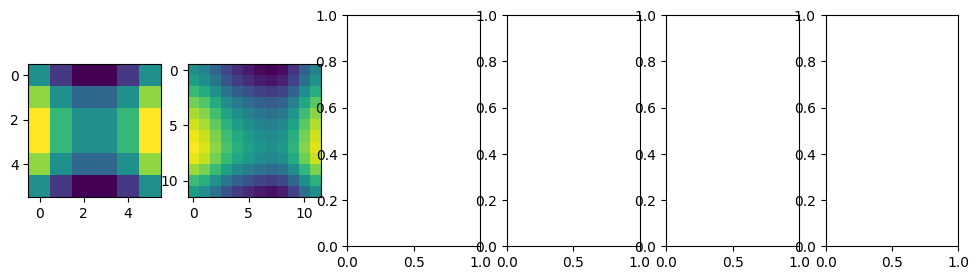

In [10]:
def spectral_fourier_interpolation(data, target_shape):
    current_shape = data.shape
    target_height, target_width = target_shape

    # Apply FFT and shift to center frequencies
    data_f = torch.fft.fft2(data)
    data_f = torch.fft.fftshift(data_f)  # Shift DC component to center

    # Create a new frequency domain matrix
    data_f_resized = torch.zeros((target_height, target_width), dtype=torch.complex64)

    # Compute the frequency ranges
    y_min = (target_height - current_shape[0]) // 2
    y_max = y_min + current_shape[0]
    x_min = (target_width - current_shape[1]) // 2
    x_max = x_min + current_shape[1]

    # Copy the original frequency content into the center
    data_f_resized[y_min:y_max, x_min:x_max] = data_f

    # Apply phase shift correction to align pixels properly
    y_indices = torch.fft.fftfreq(target_height, d=1.0).to(data.device)
    x_indices = torch.fft.fftfreq(target_width, d=1.0).to(data.device)
    X, Y = torch.meshgrid(x_indices, y_indices, indexing="xy")

    phase_shift =  torch.exp(-1j * torch.pi * (- 1 * (current_shape[0] / target_height) * Y - 1 * (current_shape[1] / target_width) * X))
    data_f_resized *= phase_shift

    # Inverse FFT shift and transform back to spatial domain
    data_f_resized = torch.fft.ifftshift(data_f_resized)  # Restore original frequency order
    data_resized = torch.fft.ifft2(data_f_resized)

    return data_resized.real


x = torch.linspace(-2, 2, 6)
y = torch.linspace(-2, 2, 6)
X, Y = torch.meshgrid(x, y, indexing="xy")
ran = 100 * torch.randn(1,1,1,6,6)
Z = X**2 - Y**2
#print(Z)

Z = Z.unsqueeze(0).unsqueeze(0).unsqueeze(0)
ranZran = torch.cat([ran, Z, ran], dim=2)
#print(ranZran.shape)
fig, ax = plt.subplots(1,6, figsize=(12,3))
ax[0].imshow(Z[0,0,0])
Z2 = spectral_fourier_interpolation(Z.squeeze(), (12,12))
#Z3 = spectral_fourier_interpolation(ranZran, (12,12))
ax[1].imshow(Z2.squeeze())
#Z3 = Z2
ax[2].imshow(Z3.squeeze())
#ax[2].imshow(Z3.squeeze()[1])
#Z4 = torch.roll(torch.roll(Z2, 1, 3), 1, 4)
#ax[3].imshow(Z4.squeeze())
#ax[4].imshow(Z2.squeeze() - Z3.squeeze()[1])
#ax[5].imshow()

In [ ]:
fig, ax = plt.subplots(1,7, figsize=(12,2.5))
x = torch.linspace(-2, 2, 5)
print(x)
y = torch.linspace(-2, 2, 5)
X, Y = torch.meshgrid(x, y, indexing="xy")
Z = - (X)**2 - abs(Y)

#ax[0].imshow(Z.squeeze())
Zpadded = torch.nn.functional.pad(Z, (0, 5, 0, 5), value=0)
ax[0].imshow(Zpadded.squeeze())
print(Zpadded.shape)
new = torch.fft.fftn(Zpadded, dim=(-2, -1))
new = torch.fft.fftshift(new, dim=(-2, -1))
print(new.shape)
ax[1].imshow(new.real.squeeze())
new = torch.fft.ifftshift(new, dim=(-2, -1))
ax[2].imshow(new.real.squeeze())
new = torch.fft.ifftn(new, dim=(-2, -1)).real
ax[3].imshow(new.squeeze())


plt.tight_layout()
plt.show()



In [ ]:
import torch
from torch.utils.data import Dataset
import h5py
from pathlib import Path

class AmiraDataset(Dataset):
    def __init__(self, filepaths):
        self.data_list = []
        self.lengths = []
        
        for filepath in filepaths:
            with h5py.File(filepath, 'r') as f:
                data = torch.from_numpy(f['velocity'][:])
                data = data.permute(0,3,1,2)
                self.data_list.append(data)
                self.lengths.append(len(data) - 1)
        
        self.cumulative_lengths = torch.cumsum(torch.tensor(self.lengths), dim=0)

    def __len__(self):
        return sum(self.lengths)

    def __getitem__(self, idx):
        # Determine which file the index belongs to
        file_idx = next(i for i, cl in enumerate(self.cumulative_lengths) if idx < cl)
        local_idx = idx if file_idx == 0 else idx - self.cumulative_lengths[file_idx - 1]
        
        data = self.data_list[file_idx][local_idx]
        label = self.data_list[file_idx][local_idx + 1]
        
        return data.unsqueeze(0), label.unsqueeze(0)

'''
filenames = ['4999.h5', '5999.h5', '6999.h5', '7999.h5']
filebase = 'data/prjs1359/AmiraSet/'
filepaths = [filebase + filename for filename in filenames]
dataset = AmiraDataset(filepaths)
loader = DataLoader(dataset, batch_size=8, shuffle=False)
for x, y in loader:
    print(x.shape, y.shape)
    break
'''

In [ ]:
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)
for x, y in dataloader:
    break
def plotvelxy(data):
    fig, ax = plt.subplots(2,10, figsize=(15,4))
    for i in range(10):
        ax[0,i].imshow(x[i,0,0,:,:])
        ax[1,i].imshow(x[i,0,1,:,:])
    absmean = x.abs().mean()
    plt.suptitle("mean magnitude: " + str(absmean.numpy()))
    plt.tight_layout()
    plt.show()
plotvelxy(x)

In [ ]:
loader = DataLoader(dataset, batch_size=1000, shuffle=False)
for x, y in loader:
    print('max: ', x.max())

In [ ]:
class PDEBenchCompDataset(Dataset):
    def __init__(self, filepaths):
        self.data_list = []
        self.traj_list = []
        self.ts = None

        for filepath in filepaths:
            with h5py.File(filepath, "r") as f:
                keys = list(f.keys())
                print(f"Keys in {filepath}: {keys}")
                
                if "Vx" in keys and "Vy" in keys:
                    data = torch.from_numpy(
                        np.stack((f["Vx"][:], f["Vy"][:]), axis=2).astype(np.float32)
                    )
                    
                    if self.ts is None:
                        self.ts = data.shape[1]
                    elif self.ts != data.shape[1]:
                        raise ValueError("Mismatch in timestep dimensions across files.")
                    
                    self.data_list.append(data)
                    self.traj_list.append(data.shape[0])
        
        self.data = torch.cat(self.data_list, dim=0)
        self.traj = sum(self.traj_list)
        
    def __len__(self):
        return self.traj * (self.ts - 1)

    def __getitem__(self, idx):
        traj_idx = idx // (self.ts - 1)
        ts_idx = idx % (self.ts - 1)
        
        return self.data[traj_idx][ts_idx].unsqueeze(0), self.data[traj_idx][ts_idx + 1].unsqueeze(0)




filenames = ['2D_CFD_Rand_M0.1_Eta0.01_Zeta0.01_periodic_128_Train.hdf5']#, '2D_CFD_Rand_M1.0_Eta0.01_Zeta0.01_periodic_128_Train.hdf5']
filebase = 'data/prjs1359/PDEBench-Comp/'
filepaths = [filebase + filename for filename in filenames]
dataset = PDEBenchCompDataset(filepaths)
loader = DataLoader(dataset, batch_size=8, shuffle=False)
for x, y in loader:
    print(x.shape, y.shape)
    break

In [ ]:
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)
for x, y in dataloader:
    break
def plotvelxy(data):
    fig, ax = plt.subplots(2,10, figsize=(15,4))
    for i in range(10):
        ax[0,i].imshow(x[i,0,0,:,:])
        ax[1,i].imshow(x[i,0,1,:,:])
    absmean = x.abs().mean()
    plt.suptitle("mean magnitude: " + str(absmean.numpy()))
    plt.tight_layout()
    plt.show()
plotvelxy(x)

In [ ]:
loader = DataLoader(dataset, batch_size=999, shuffle=False)
for x, y in loader:
    print('max: ', x.max())

In [ ]:

class PDEBenchInCompDataset(Dataset):
    def __init__(self, filepaths, resample_shape=(256, 256), resample_mode='fourier', timesample=10):
        self.data_list = []
        self.traj_list = []
        self.ts = None
        self.resample_shape = resample_shape
        self.resample_mode = resample_mode
        
        for filepath in filepaths:
            with h5py.File(filepath, "r") as f:
                keys = list(f.keys())
                print(f"Keys in {filepath}: {keys}")
                
                if "velocity" in keys:
                    data = torch.from_numpy(f['velocity'][:,::timesample].astype(np.float32))
                    print(data.shape)
                    data = data.permute(0, 1, 4, 2, 3)  # Adjust dimensions
                    
                    if self.ts is None:
                        self.ts = data.shape[1]
                    elif self.ts != data.shape[1]:
                        raise ValueError("Mismatch in timestep dimensions across files.")
                    
                    self.data_list.append(data)
                    self.traj_list.append(data.shape[0])
                #if "t" in keys:
                #    self.data_t = torch.from_numpy(f['t'][:].astype(np.float32))
                #    print(self.data_t.shape)
        
        self.data = torch.cat(self.data_list, dim=0)
        self.traj = sum(self.traj_list)
        print(self.traj)
        print(self.ts)
        
    def __len__(self):
        return self.traj * (self.ts - 1)

    def __getitem__(self, idx):
        traj_idx = idx // (self.ts - 1)
        ts_idx = idx % (self.ts - 1)
        
        front = self.data[traj_idx][ts_idx]
        label = self.data[traj_idx][ts_idx + 1]
        front = spatial_resample(front, self.resample_shape, self.resample_mode)
        label = spatial_resample(label, self.resample_shape, self.resample_mode)
        return front.unsqueeze(0), label.unsqueeze(0)


filepath = 'data/prjs1359/PDEBench-InComp/'
file_names = ['ns_incom_inhom_2d_512-0.h5']#, 'ns_incom_inhom_2d_512-10.h5', 'ns_incom_inhom_2d_512-100.h5']
filepaths = [filepath + filename for filename in file_names]
dataset = PDEBenchInCompDataset(filepaths)

In [ ]:
test = torch.tensor([0,1,2,3,4,5,6,7,8,9])
test[::5]
dataset.data_t[0,::10]#[::200]

In [ ]:
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)
for x, y in dataloader:
    break
def plotvelxy(data):
    fig, ax = plt.subplots(2,10, figsize=(15,4))
    for i in range(10):
        ax[0,i].imshow(x[i,0,0,:,:])
        ax[1,i].imshow(x[i,0,1,:,:])
    absmean = x.abs().mean()
    plt.suptitle("mean magnitude: " + str(absmean.numpy()))
    plt.tight_layout()
    plt.show()
plotvelxy(x)

In [ ]:
loader = DataLoader(dataset, batch_size=999, shuffle=False)
for x, y in loader:
    print('max: ', x.max())

In [ ]:

class PDEGymDataset(Dataset):
    def __init__(self, filepaths, resample_shape=(256, 256), resample_mode='fourier', timesample=1):

        self.data = []
        self.resample_shape = resample_shape
        self.resample_mode = resample_mode
        for filepath in filepaths:
            with nc.Dataset(filepath, "r") as f:
                velocity = torch.from_numpy(f['velocity'][:,::timesample,:2])  # remove passive tracer
                self.data.append(velocity)  

        self.data = torch.cat(self.data, dim=0) 
        self.traj = self.data.shape[0]
        self.ts = self.data.shape[1]
        print(self.ts)

    def __len__(self):
        return self.traj * (self.ts - 1)

    def __getitem__(self, idx):
        traj_idx = idx // (self.ts - 1)
        ts_idx = idx % (self.ts - 1)

        front = self.data[traj_idx][ts_idx]
        label = self.data[traj_idx][ts_idx + 1]
        front = spatial_resample(front, self.resample_shape, self.resample_mode)
        label = spatial_resample(label, self.resample_shape, self.resample_mode)
        return front.unsqueeze(0), label.unsqueeze(0)
basepath = 'data/prjs1359/PDEGym-NSGauss/'
filepath = ['velocity_0.nc', 'velocity_1.nc']
filepaths = [basepath + file for file in filepath]
dataset = PDEGymDataset(filepaths)
loader = DataLoader(dataset, batch_size=3, shuffle=False)


j = 0
for x, y in loader:
    print(x.shape, y.shape)
    break
    #fig, ax = plt.subplots(2,3, figsize=(12,4))
    #for i in range(3):
    #    ax[0,i].imshow(x[:,:,i,:,:].squeeze())
    #    ax[1,i].imshow(y[:,:,i,:,:].squeeze())
    #plt.tight_layout()
    #plt.show()
    #if j==30:
    #    break
    #j = j + 1

In [ ]:
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)
for x, y in dataloader:
    break
def plotvelxy(data):
    fig, ax = plt.subplots(2,10, figsize=(15,4))
    for i in range(10):
        ax[0,i].imshow(x[i,0,0,:,:])
        ax[1,i].imshow(x[i,0,1,:,:])
    absmean = x.abs().mean()
    plt.suptitle("mean magnitude: " + str(absmean.numpy()))
    plt.tight_layout()
    plt.show()
plotvelxy(x)

In [ ]:
def read_amira_mesh(filename):
    with open(filename, 'rb') as f:  # Open in binary mode
        data = f.read()  # Read raw binary data
    return data  # Returns raw binary content

# Usage
amira_data = read_amira_mesh("data/prjs1359/AmiraSet/0000.am")
print(amira_data[:100])
print(amira_data[100:200])  # Print first 100 bytes to inspect the format
print(amira_data[200:300])  # Print first 100 bytes to inspect the format
print(amira_data[300:400])  # Print first 100 bytes to inspect the format


In [ ]:
basedir = "data/prjs1359/"
extdirs = ['AmiraSet', 'PDEBench-Comp', 'PDEBench-InComp', 'PDEGym-NSGauss', 'PDEGym-NSSines']
dirs = [Path(basedir + extdir) for extdir in extdirs]
files = [f for f in dirs.iterdir() if f.is_file()]  # List files
files = list(dir.glob("*.h5"))


In [ ]:
def get_dataset(folderPath):
    dir = Path(folderPath)
    assert dir.exists(), 'doesnt exist homie'
    files = list(dir.glob("*.h5"))
    return AmiraDataset(files)
dataset = get_dataset('data/prjs1359/AmiraSet')

In [ ]:
import numpy as np

def read_amira_binary_mesh(filename):
    with open(filename, 'rb') as f:
        raw_data = f.read()

    # Locate the first occurrence of "@1"
    first_marker_idx = raw_data.find(b'@1')
    if first_marker_idx == -1:
        raise ValueError("Could not find binary data section in Amira file.")

    # Locate the second occurrence of "@1"
    second_marker_idx = raw_data.find(b'@1', first_marker_idx + 2)
    if second_marker_idx == -1:
        raise ValueError("Could not find second binary data section in Amira file.")
    
    # The second @1 starts right after its occurrence
    data_start = second_marker_idx + 4  # Skip '@1\n'
    
    # Extract the binary data
    #print(raw_data[:data_start])
    binary_data = raw_data[data_start:]
    #print(binary_data[:100])

    # Define shape (from header: 512 x 512 x 1001, 2 channels per voxel)
    #lattice_shape = (512, 512, 1001, 2)
    lattice_shape = (1001, 512, 512, 2)

    # Read as float32 (Little-Endian)
    #float_data = np.frombuffer(binary_data, dtype=np.float32, count=1000)
    float_data = np.frombuffer(binary_data, dtype=np.float32)#, count=512*512)
    #print(float_data[:100])
    # Reshape
    float_data = float_data.reshape(lattice_shape)

    return float_data

# Usage
#amira_data = read_amira_binary_mesh("data/0000.am")

# Print shape and a sample slice
#print("Data shape:", amira_data.shape)
#print("First voxel values:", amira_data[0, 0, 0])
#ti = 100
#print("First 10 values:", amira_data[:ti])  # Print first 10 values to inspect the format
# print average
#print("Average value:", np.mean(amira_data[:ti]))


In [ ]:
amira_data = read_amira_binary_mesh("data/prjs1359/AmiraSet/3999.am") # should be mid-rough initial condition
amira_data.shape


In [ ]:
class AmiraDataset(Dataset):
    def __init__(self, filepaths, resample_shape=(256, 256), resample_mode='fourier', timesample=5):
        self.data_list = []
        self.traj_list = []
        self.ts = None
        self.resample_shape = resample_shape
        self.resample_mode = resample_mode
        
        for filepath in filepaths:
            data = torch.from_numpy(self.read_amira_binary_mesh(filepath))
            data = data[::timesample].permute(0,3,1,2)
            self.data_list.append(data)
            self.traj_list.append(torch.tensor(1))
            if self.ts is None:
                self.ts = data.shape[1]
        
        self.data = torch.stack(self.data_list, dim=0)
        print(self.data.shape)
        self.traj = sum(self.traj_list)

    def __len__(self):
        return self.traj * (self.ts - 1)

    def __getitem__(self, idx):
        traj_idx = idx // (self.ts - 1)
        ts_idx = idx % (self.ts - 1)
        
        front = self.data[traj_idx][ts_idx]
        label = self.data[traj_idx][ts_idx + 1]
        #print(data.shape, label.shape)
        front = spatial_resample(front, self.resample_shape, mode=self.resample_mode)
        label = spatial_resample(label, self.resample_shape, mode=self.resample_mode)
        return front.unsqueeze(0), label.unsqueeze(0)

    def read_amira_binary_mesh(self, filename):
        with open(filename, 'rb') as f:
            raw_data = f.read()
        # first occurrence of "@1"
        first_marker_idx = raw_data.find(b'@1')
        if first_marker_idx == -1:
            raise ValueError("Could not find binary data section in Amira file.")
        # second occurrence of "@1"
        second_marker_idx = raw_data.find(b'@1', first_marker_idx + 2)
        if second_marker_idx == -1:
            raise ValueError("Could not find second binary data section in Amira file.")
        data_start = second_marker_idx + 4  # Skip '@1\n'
        binary_data = raw_data[data_start:]
        lattice_shape = (1001, 512, 512, 2)
        float_data = np.frombuffer(binary_data, dtype=np.float32)
        float_data = float_data.reshape(lattice_shape)
        return float_data

In [ ]:
from src.dataloaders.utils import spatial_resample
filenames = ['6999.am','7999.am']
filebase = 'data/prjs1359/AmiraSet/'
filepaths = [filebase + filename for filename in filenames]
dataset = AmiraDataset(filepaths, resample_shape=(256, 256), resample_mode='fourier')
loader = DataLoader(dataset, batch_size=8, shuffle=False)
for x, y in loader:
    print(x.shape, y.shape)
    break

In [ ]:
ts = np.linspace(0, 100, 10).astype(int)
fig, ax = plt.subplots(2, len(ts), figsize=(25, 8))
for i, t in enumerate(ts):
    ax[0,i].imshow(amira_data[t,:,:,0])
    #ax[i,0].set_title(f"t={t}")
    ax[1,i].imshow(amira_data[t,:,:,1])
    ax[0,i].set_title(f"t={t}")
plt.tight_layout()
plt.show()

In [ ]:
fold = nn.Fold(output_size=(8, 8), kernel_size=(2, 2), stride=(2, 2))
unfold = nn.Unfold(kernel_size=(2, 2), stride=(2, 2))
x = torch.randn(1, 1, 8, 8)
x_unfold = unfold(x)
print(x_unfold.shape)
x_fold = fold(x_unfold)
print(x_fold.shape)

In [ ]:
import numpy as np

def read_binary_amira_mesh(filename):
    with open(filename, 'rb') as f:
        raw_data = f.read()

    # Locate binary data section
    marker_idx = raw_data.find(b'@1')
    if marker_idx == -1:
        raise ValueError("Could not find binary data section in Amira file.")

    data_start = marker_idx + 3  # Skip '@1\n'
    
    # Use the correct dtype (update this based on your test)
    float_data = np.frombuffer(raw_data[data_start:], dtype=np.float64)  # or np.float32, np.int16
    
    # Reshape correctly
    data_shape = (512, 512, 1001, 2)  # Update based on actual channels
    float_data = float_data.reshape(data_shape)

    return float_data

# Run the function
amira_data = read_binary_amira_mesh("data/0000.am")
print("Data shape:", amira_data.shape)
print("Sample values:", amira_data[0, 0, 0])


In [ ]:

def window_partition(x, window_size):

    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):

    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

class MLP(nn.Module): #might change name to FFN
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class ConvNeXtBlock(nn.Module):
    r"""Taken from: https://github.com/facebookresearch/ConvNeXt/blob/main/models/convnext.py
    ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch

    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """

    def __init__(self, emb_dim, layer_scale_init_value=1e-6, layer_norm_eps=1e-5):
        super().__init__()
        self.dwconv = nn.Conv2d(
            emb_dim, emb_dim, kernel_size=7, padding=3, groups=emb_dim
        )  # depthwise conv
        
        self.norm = nn.LayerNorm(emb_dim, eps=layer_norm_eps)
        self.pwconv1 = nn.Linear(
            emb_dim, 4 * emb_dim
        )  # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * emb_dim, emb_dim)
        self.weight = (
            nn.Parameter(layer_scale_init_value * torch.ones((emb_dim)), requires_grad=True)
            if layer_scale_init_value > 0
            else None
        )  # was gamma before
        

    def forward(self, x):
        batch_size, sequence_length, hidden_size = x.shape
        #! assumes square images
        input_dim = math.floor(sequence_length**0.5)

        input = x
        x = x.reshape(batch_size, input_dim, input_dim, hidden_size)
        #print(x.shape)
        x = x.permute(0, 3, 1, 2)
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.weight is not None:
            x = self.weight * x
        x = x.reshape(batch_size, sequence_length, hidden_size)

        x = input + x
        return x
    

class ResNetBlock(nn.Module):
    # taken from poseidon code
    def __init__(self, config, dim):
        super().__init__()
        kernel_size = 3
        pad = (kernel_size - 1) // 2
        self.conv1 = nn.Conv2d(dim, dim, kernel_size=kernel_size, stride=1, padding=pad)
        self.conv2 = nn.Conv2d(dim, dim, kernel_size=kernel_size, stride=1, padding=pad)
        self.bn1 = nn.BatchNorm2d(dim)
        self.bn2 = nn.BatchNorm2d(dim)

    def forward(self, x):
        batch_size, sequence_length, hidden_size = x.shape
        input_dim = math.floor(sequence_length**0.5)

        input = x
        x = x.reshape(batch_size, input_dim, input_dim, hidden_size)
        x = x.permute(0, 3, 1, 2)
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.leaky_relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = x.permute(0, 2, 3, 1)
        x = x.reshape(batch_size, sequence_length, hidden_size)
        x = x + input
        return x


class LinearEmbedding(nn.Module):

    def __init__(self, emb_dim = 96, data_dim = (1,5,4,128,128), patch_size = (8,8), hiddenout_dim = 256):
        super().__init__()
        
        self.B, self.T, self.C, self.H, self.W = data_dim
        self.emb_dim = emb_dim
        self.pH, self.pW = patch_size
        self.hiddenout_dim = hiddenout_dim
        self.patch_grid_res = (self.H // self.pH, self.W // self.pW)
        
        act = nn.GELU

        assert self.H % self.pH == 0 and self.W % self.pW == 0, "spatial input dim must be divisible by patch_size"
        assert self.H == self.W, "must be square"
        

        self.patchify = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        self.unpatchify = nn.Fold(output_size=(self.H, self.W), kernel_size=patch_size, stride=patch_size)

        #self.patch_position_embeddings = get_embeddings((1, 1, config.patch_num * config.patch_num, self.dim))
        #self.time_embed = get_embeddings((1, config.get("max_time_len", 20), 1, self.dim))

        self.pre_proj = nn.Sequential(
            nn.Linear(self.C * self.pH * self.pW, self.emb_dim),
            act(),
            nn.Linear(self.emb_dim, self.emb_dim),
        )

        self.post_proj = nn.Sequential(
            nn.Linear(self.emb_dim, self.hiddenout_dim),
            act(),
            nn.Linear(self.hiddenout_dim, self.hiddenout_dim),
            act(),
            nn.Linear(self.hiddenout_dim, self.C * self.pH * self.pW),
        )

    #def get_pos_embeddings(self, t_len):
    #    return (self.time_embed[:, :t_len] + self.patch_position_embeddings).view(1, -1, self.emb_dim)  # (1, t*p*p, d)

    def encode(self, x, proj=True):

        B = x.size(0)
        #print(1, x.shape)
        x = rearrange(x, "b t c h w -> (b t) c h w") #might change to .permute
        #print(2, x.shape)
        x = self.patchify(x)  
        #print(3, x.shape)
        x = rearrange(x, "(b t) d pp -> b (t pp) d", b=B) # should think about this
        #print(4, x.shape)

        # TODO: add Positional Encoding
        if proj:
            #print(5, x.shape)
            return self.pre_proj(x)#.transpose(1, 2)
        else:
            return x#.transpose(1, 2)

    def decode(self, x, proj=True):
        if proj:
            x = self.post_proj(x)  

        B = x.size(0)
        x = rearrange(x, "b (t pp) d -> (b t) d pp", pp=self.patch_grid_res[0]*self.patch_grid_res[1]) #might change to .permute
        x = self.unpatchify(x)  
        #print(x.shape)
        x = rearrange(x, "(b t) c h w -> b t c h w", b=B)

        return x
    
 
class PatchMerge(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.linear = nn.Linear(4*emb_dim, 2*emb_dim)

    def forward(self, x):
        B, L, C = x.shape
        H = W = int(np.sqrt(L)/2)
        x = rearrange(x, 'b (h s1 w s2) c -> b (h w) (s1 s2 c)', s1=2, s2=2, h=H, w=W) #might change to .permute
        x = self.linear(x)
        return x

class PatchUnMerge(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.linear = nn.Linear(emb_dim, 2*emb_dim)
    
    def forward(self, x):
        B, L, C = x.shape
        H = W = int(np.sqrt(L))
        #print(x.shape, H, W)
        x = self.linear(x)
        #print(x.shape)
        x = rearrange(x, 'b (h w) (s1 s2 c) -> b (h s1 w s2) c', s1=2, s2=2, h=H, w=W) #might change to .permute
        return x


class WindowAttention(nn.Module):

    def __init__(self, emb_dim, window_size, num_heads, qkv_bias=True, use_flex_attn=True):

        super().__init__()
        self.emb_dim = emb_dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.qkv_bias = qkv_bias
        self.use_flex_attn = use_flex_attn # original from logits scale BCAT?

        assert emb_dim % num_heads == 0, "embedding dimension must be divisible by number of heads"

        
        if self.use_flex_attn: 
            self.flex_attn = nn.Parameter(torch.log(10 * torch.ones((num_heads, 1, 1))), requires_grad=True)

        # mlp to generate continuous relative position bias
        self.cpb_mlp = nn.Sequential(nn.Linear(2, 512, bias=True),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(512, num_heads, bias=False))

        # get relative_coords_table
        relative_coords_h = torch.arange(-(self.window_size[0] - 1), self.window_size[0], dtype=torch.float32)
        relative_coords_w = torch.arange(-(self.window_size[1] - 1), self.window_size[1], dtype=torch.float32)
        relative_coords_table = torch.stack(
            torch.meshgrid([relative_coords_h,
                            relative_coords_w])).permute(1, 2, 0).contiguous().unsqueeze(0)  
        
        relative_coords_table[:, :, :, 0] /= (self.window_size[0] - 1)
        relative_coords_table[:, :, :, 1] /= (self.window_size[1] - 1)
        relative_coords_table *= 8  # normalize to -8, 8 TODO: understand why
        relative_coords_table = torch.sign(relative_coords_table) * torch.log2(
            torch.abs(relative_coords_table) + 1.0) / np.log2(8)

        self.register_buffer("relative_coords_table", relative_coords_table)

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w])) 
        coords_flatten = torch.flatten(coords, 1)  
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  
        relative_coords[:, :, 0] += self.window_size[0] - 1  
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(emb_dim, emb_dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(emb_dim))
            self.v_bias = nn.Parameter(torch.zeros(emb_dim))
            # TODO: understand why not key bias
        else:
            self.q_bias = None
            self.v_bias = None
        self.proj_out = nn.Linear(emb_dim, emb_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):

        B, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
        #print(x.shape, self.qkv.weight.shape, qkv_bias.shape)
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        #print('test')
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        # cosine attention
        attn = (F.normalize(q, dim=-1) @ F.normalize(k, dim=-1).transpose(-2, -1))
        if self.use_flex_attn:
            flex_attn = torch.clamp(self.flex_attn, max=torch.log(torch.tensor(1. / 0.01))).exp()
            attn = attn * flex_attn

        relative_position_bias_table = self.cpb_mlp(self.relative_coords_table).view(-1, self.num_heads)
        relative_position_bias = relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1) 
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  
        relative_position_bias = 16 * torch.sigmoid(relative_position_bias)
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj_out(x)
        return x
    
class SwinV2Block(nn.Module): #change name to something else

    def __init__(self, emb_dim, patch_grid_res, num_heads, window_size=4, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, use_flex_attn=True, use_proj_in=True, 
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.emb_dim = emb_dim
        self.patch_grid_res = patch_grid_res
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        #self.use_proj_in = use_proj_in
        
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(emb_dim)
        #print('test')
        self.attn = WindowAttention(
            emb_dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, use_flex_attn=use_flex_attn)
        #print('test')
        self.norm2 = norm_layer(emb_dim)
        mlp_hidden_dim = int(emb_dim * mlp_ratio)
        self.mlp = MLP(in_features=emb_dim, hidden_features=mlp_hidden_dim, act_layer=act_layer)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA (from original swin paper source code)
            H, W = self.patch_grid_res
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            #print('test')
            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.patch_grid_res
        B, L, C = x.shape
        #print(L, H, W)
        #print('t', x.shape)
        #if self.use_proj_in:
        #    x = x.transpose(1,2)
        #    x = self.proj_in(x)
        #    x = x.transpose(1,2)
        #else:
        assert L == H * W, "input feature has wrong size for window partitioning (use proj_in=True for projection)"
        #print('u', x.shape)
        shortcut = x
        x = x.view(B, H, W, C)

        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        #TODO: save attention mask somewhere?
        
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)
        x = shortcut + self.norm1(x)

        x = x + self.norm2(self.mlp(x))

        return x
    
class SwinStage(nn.Module): # change name since stage also includes patch merge formally
    
    def __init__(self, emb_dim, patch_grid_res, stage_depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, use_flex_attn=True,
                 norm_layer=nn.LayerNorm):

        super().__init__()
        self.emb_dim = emb_dim
        self.patch_grid_res = patch_grid_res
        self.stage_depth = stage_depth

        assert stage_depth % 2 == 0, "stage depth must be divisible by 2"

        # build blocks
        self.blocks = nn.ModuleList([
            SwinV2Block(emb_dim=emb_dim, patch_grid_res=patch_grid_res,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, 
                                 use_flex_attn=use_flex_attn,
                                 norm_layer=norm_layer
                                 )
            for i in range(stage_depth)])

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        return x
    
class SwinUnet(nn.Module):
    def __init__(self, emb_dim, data_dim, patch_size, hiddenout_dim, depth, 
                 stage_depths, num_heads, window_size=8, mlp_ratio=4., 
                 qkv_bias=True, use_flex_attn=True, norm_layer=nn.LayerNorm,
                 act=nn.GELU, skip_connect=ConvNeXtBlock):
        super().__init__()

        self.embedding = LinearEmbedding(emb_dim, data_dim, patch_size, hiddenout_dim)

        self.blockDown = nn.ModuleList()
        self.blockUp = nn.ModuleList()
        self.patchMerges = nn.ModuleList()
        self.patchUnmerges = nn.ModuleList()
        self.skip_connects = nn.ModuleList()
        # TODO: implement act 

        self.depth = depth

        for i in range(depth):
            patch_grid_res = (data_dim[3] // (patch_size[0] * 2**i), data_dim[4] // (patch_size[1] * 2**i))
            
            #print(emb_dim * 2**i, patch_grid_res, stage_depths[i], num_heads[i], window_size)
            self.blockDown.append(
                SwinStage(
                    emb_dim * 2**i, 
                    patch_grid_res=patch_grid_res,
                    stage_depth=stage_depths[i], 
                    num_heads=num_heads[i], 
                    window_size=window_size, 
                    mlp_ratio = mlp_ratio, 
                    qkv_bias = qkv_bias, 
                    use_flex_attn = use_flex_attn, 
                    norm_layer = norm_layer
                )
            )
            self.patchMerges.append(PatchMerge(emb_dim * 2**i))
            #self.skip_connects.append(skip_connect(emb_dim * 2**i, 
            #                                       layer_scale_init_value=1e-6, 
            #                                       layer_norm_eps=1e-5))


        #print(emb_dim * 2**depth, (data_dim[3] // (patch_size[0] * 2**depth), data_dim[4] // (patch_size[1] * 2**depth)))
        self.blockMiddle = SwinStage(
            emb_dim * 2**depth,
            patch_grid_res=(data_dim[3] // (patch_size[0] * 2**depth), data_dim[4] // (patch_size[1] * 2**depth)),
            stage_depth=stage_depths[depth],
            num_heads=num_heads[depth],
            window_size=window_size,
            mlp_ratio=mlp_ratio,
            qkv_bias=qkv_bias,
            use_flex_attn=use_flex_attn,
            norm_layer=norm_layer
        )

        for i in reversed(range(depth)):
            patch_grid_res = (data_dim[3] // (patch_size[0] * 2**i), data_dim[4] // (patch_size[1] * 2**i))
            #print(emb_dim * 2**i, patch_grid_res, stage_depths[2*depth - i], num_heads[2*depth - i], window_size)

            self.blockUp.append(
                SwinStage(
                    emb_dim * 2**i, 
                    patch_grid_res=patch_grid_res,
                    stage_depth=stage_depths[2*depth - i], 
                    num_heads=num_heads[2*depth - i], 
                    window_size=window_size, 
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    use_flex_attn=use_flex_attn,
                    norm_layer=norm_layer
                )
            )
            self.patchUnmerges.append(PatchUnMerge(emb_dim * 2**(i+1)))
            self.skip_connects.append(skip_connect(emb_dim * 2**i,
                                                   layer_scale_init_value=1e-6,
                                                   layer_norm_eps=1e-5))

    def forward(self, x):
        skips = []

        x = self.embedding.encode(x, proj=True)
        #print(x.shape)
        for i in range(self.depth):
            #print(i)
            x = self.blockDown[i](x)
            #print(x.shape)
            skips.append(x)
            x = self.patchMerges[i](x)
            #print(x.shape)
        #print('middle')
        x = self.blockMiddle(x)
        #print(x.shape)
        for i in range(self.depth):
            #print(i)
            x = self.patchUnmerges[i](x)
            #print(x.shape)
            x = x + self.skip_connects[i](skips[self.depth - i - 1])
            #print(x.shape)
            x = self.blockUp[i](x)
            #print(x.shape)

        x = self.embedding.decode(x, proj=True)

        return x


# 2 depth example
x = torch.randn(1, 1, 1, 256, 256).to(torch.device('cuda'))
model = SwinUnet(emb_dim=96,
                data_dim=x.shape,
                patch_size=(4,4),
                hiddenout_dim=256,
                depth=2,
                stage_depths=[2, 2, 6, 2, 2],
                num_heads=[3, 6, 12, 6, 3],
                window_size=4, 
                act=nn.GELU,
                skip_connect=ConvNeXtBlock,
                device=torch.device('cuda')).to(torch.device('cuda'))
y = model(x)
# count trainable params
print(sum(p.numel() for p in model.parameters() if p.requires_grad))


# 3 depth example
x2 = torch.randn(1, 1, 1, 512, 512)
model2 = SwinUnet(emb_dim=96,
                  data_dim=x2.shape,
                  patch_size=(4,4),
                    hiddenout_dim=256,
                    depth=3,
                    stage_depths=[2, 2, 2, 6, 2, 2, 2],
                    num_heads=[3, 6, 12, 24, 12, 6, 3],
                    window_size=4,
                    act=nn.GELU,
                    skip_connect=ConvNeXtBlock)
y2 = model2(x2)
print(sum(p.numel() for p in model2.parameters() if p.requires_grad))

In [ ]:

x = torch.randn(2, 1, 4, 32, 32)
patch_size = (4, 4)
layer1 = LinearEmbedding(data_dim=x.shape, emb_dim=96, patch_size=patch_size, hiddenout_dim=256)

layer2 = SwinStage(emb_dim=96, 
                   patch_grid_res=(x.shape[3] // patch_size[0], x.shape[4] // patch_size[0]), 
                   stage_depth=2,
                   num_heads=3, 
                   window_size=4
                   )
layer3 = PatchMerge(emb_dim=96)
layer4 = SwinStage(emb_dim=192, 
                   patch_grid_res=(x.shape[3] // patch_size[0] // 2, x.shape[4] // patch_size[0] // 2), 
                   stage_depth=4,
                   num_heads=6, 
                   window_size=4
                   )
layer5 = PatchUnMerge(emb_dim=192)
layer6 = SwinStage(emb_dim=96, 
                   patch_grid_res=(x.shape[3] // patch_size[0], x.shape[4] // patch_size[0]), 
                   stage_depth=2,
                   num_heads=3, 
                   window_size=4
                   )
convnext = ConvNeXtBlock(emb_dim=96)

print(x.shape)
x = layer1.encode(x)
print(x.shape)
x = layer2(x)
shortcut = x

x = layer3(x)

x = layer4(x)
print(x.shape)

#x = convnext(shortcut) + layer5(x)
x = layer5(x)
print(x.shape)
x = layer6(x)

x = layer1.decode(x)




In [ ]:

import torch
from torch.utils.data import ConcatDataset, Dataset
import torchvision
import h5py
import random

class HDF5ConcatDataset(ConcatDataset):
    def __init__(self, datasets):
        super().__init__(datasets)

    def time_window(self):
        return self.datasets[0].time_window

    def absmax_vel(self):
        return max(d.absmax_vel() for d in self.datasets)

    def absmax_temp(self):
        return max(d.absmax_temp() for d in self.datasets)
    
    def absmax_phase(self):
        return max(d.absmax_phase() for d in self.datasets)
    
    def _get_temp_full(self, num):
        return self.datasets[num]._data['temp']

    def normalize_temp_(self, absmax_temp=None):
        if not absmax_temp:
            absmax_temp = self.absmax_temp()
        for d in self.datasets:
            d.normalize_temp_(absmax_temp)
        return absmax_temp

    def normalize_vel_(self, absmax_vel=None):
        if not absmax_vel:
            absmax_vel = self.absmax_vel()
        for d in self.datasets:
            d.normalize_vel_(absmax_vel)
        return absmax_vel
    
    def normalize_phase_(self, absmax_phase=None):
        if not absmax_phase:
            absmax_phase = self.absmax_phase()
        for d in self.datasets:
            d.normalize_phase_(absmax_phase)
        return absmax_phase

    def datum_dim(self):
        return self.datasets[0].datum_dim()
    
    def get_validation_stacks(self, dataset_num):
        
        if dataset_num >= len(self.datasets) or dataset_num < 0:
            raise IndexError(f"Dataset index {dataset_num} is out of range. Total datasets: {len(self.datasets)}")

        dataset = self.datasets[dataset_num]

        temp_data = dataset._data['temp'] 
        velx_data = dataset._data['velx']  
        vely_data = dataset._data['vely'] 
        phase_data = dataset._data['dfun']


        interleaved_vel = torch.empty(
        velx_data.size(0) * 2, velx_data.size(1), velx_data.size(2),
        dtype=velx_data.dtype, device=velx_data.device
        )  

        interleaved_vel[0::2] = velx_data  # Fill even indices with velx
        interleaved_vel[1::2] = vely_data  # Fill odd indices with vely

        temp_data = temp_data.unsqueeze(0)        
        interleaved_vel = interleaved_vel.unsqueeze(0)  
        phase_data = phase_data.unsqueeze(0)         
        #del velx_data, vely_data
        return temp_data, interleaved_vel, phase_data
    
    

class PFLoader(Dataset):
    def __init__(self,
                 filename,
                 discard_first,
                 use_coords,
                 time_window,
                 push_forward_steps=0,
                 transform=False):
        #super().__init__()
        self.time_window = time_window
        self.push_forward_steps = push_forward_steps
        self.filename = filename
        self.discard_first = discard_first
        self.temp_scale = None
        self.vel_scale = None
        self.phase_scale = None

        if use_coords:
            self.coords_dim = 2
        else:
            self.coords_dim = 0
        self.temp_channels = self.time_window
        self.vel_channels = self.time_window * 2
        self.phase_channels = self.time_window

        self.in_channels = self.coords_dim + self.temp_channels + self.vel_channels + self.phase_channels
        self.out_channels = 4 * self.time_window

        self.transform = transform
        self.read_files()
    
    def read_files(self):
        self._data = {}
        with h5py.File(self.filename, 'r') as f:
            self._data['temp'] = torch.nan_to_num(torch.from_numpy(f['temperature'][:][self.discard_first:])).float()
            self._data['velx'] = torch.nan_to_num(torch.from_numpy(f['velx'][:][self.discard_first:])).float()
            self._data['vely'] = torch.nan_to_num(torch.from_numpy(f['vely'][:][self.discard_first:])).float()
            self._data['dfun'] = torch.nan_to_num(torch.from_numpy(f['dfun'][:][self.discard_first:])).float()
            self._data['x'] = torch.from_numpy(f['x'][:][self.discard_first:]).float()
            self._data['y'] = torch.from_numpy(f['y'][:][self.discard_first:]).float()

        if self.temp_scale and self.vel_scale and self.phase_scale:
            self.normalize_temp_(self.temp_scale)
            self.normalize_vel_(self.vel_scale)
            self.normalize_phase_(self.phase_scale)

    def _transform(self, coords, temp, vel, phase, temp_label, vel_label, phase_label):
        if self.transform:
            if random.random() > 0.5:
                
                #coords = torchvision.transforms.functional.hflip(coords)
                temp = torchvision.transforms.functional.hflip(temp)
                vel = torchvision.transforms.functional.hflip(vel)
                phase = torchvision.transforms.functional.hflip(phase)
                temp_label = torchvision.transforms.functional.hflip(temp_label)
                vel_label = torchvision.transforms.functional.hflip(vel_label)
                phase_label = torchvision.transforms.functional.hflip(phase_label)
                
                # Flip x-velocity (even indices of the interleaved velocity tensor)
                #print(vel.shape)
                vel[0::2] *= -1  
                vel_label[0::2] *= -1 
        return (coords, temp, vel, phase, temp_label, vel_label, phase_label)

    def absmax_temp(self):
        return self._data['temp'].abs().max()

    def absmax_vel(self):
        return max(self._data['velx'].abs().max(), self._data['vely'].abs().max())
    
    def absmax_phase(self):
        return self._data['dfun'].abs().max()
    
    def normalize_temp_(self, scale):
        self._data['temp'] = 2 * (self._data['temp'] / scale) - 1
        self.temp_scale = scale

    def normalize_vel_(self, scale):
        for v in ('velx', 'vely'):
            self._data[v] = self._data[v] / scale
        self.vel_scale = scale

    def normalize_phase_(self, scale):
        self._data['dfun'] = self._data['dfun'] / scale
        self.phase_scale = scale

    def _get_temp(self, timestep):
        return self._data['temp'][timestep]
    
    def _get_phase(self, timestep):
        return torch.heaviside(self._data['dfun'][timestep], values=torch.Tensor([1]))  # pass phase as 0 to 1 values

    def _get_vel_stack(self, timestep):
        return torch.stack([
            self._data['velx'][timestep],
            self._data['vely'][timestep],
        ], dim=0)

    def _get_coords(self, timestep):
        x = self._data['x'][timestep]
        x /= x.max()
        y = self._data['y'][timestep]
        y /= y.max()
        #print('x:', x.shape, x[0], x[-1], x.min(), x.max(), x.mean())
        #print()
        #print('y:', y.shape, y[0], y[-1], y.min(), y.max(), y.mean())
        coords = torch.stack([x, y], dim=0)
        return coords

    def __len__(self):
        return self._data['temp'].size(0) - self.time_window - (self.time_window * self.push_forward_steps - 1) 

    def _get_timestep(self, timestep):
        
        coords = self._get_coords(timestep)
        temp = torch.stack([self._get_temp(timestep + k) for k in range(self.time_window)], dim=0)
        vel = torch.cat([self._get_vel_stack(timestep + k) for k in range(self.time_window)], dim=0) 
        phase = torch.stack([self._get_phase(timestep + k) for k in range(self.time_window)], dim=0)
        
        base_time = timestep + self.time_window 
        temp_label = torch.stack([self._get_temp(base_time + k) for k in range(self.time_window)], dim=0)
        vel_label = torch.cat([self._get_vel_stack(base_time + k) for k in range(self.time_window)], dim=0)
        phase_label = torch.stack([self._get_phase(base_time + k) for k in range(self.time_window)], dim=0)
        '''
        if self.time_window == 1:
            coords = coords.unsqueeze(0)  # Add the time dimension
            temp = temp.unsqueeze(0)
            vel = vel.unsqueeze(0)
            phase = phase.unsqueeze(0)
            temp_label = temp_label.unsqueeze(0)
            vel_label = vel_label.unsqueeze(0)
            phase_label = phase_label.unsqueeze(0)
        '''
        return self._transform(coords, temp, vel, phase, temp_label, vel_label, phase_label)

    def __getitem__(self, timestep):
        
        args = list(zip(*[self._get_timestep(timestep + k * self.time_window) for k in range(self.push_forward_steps)]))
        return tuple([torch.stack(arg, dim=0) for arg in args])

import yaml
path = 'conf/local_01DS8_1.yaml'
with open(path, 'r') as file:
    config = yaml.safe_load(file)
train_files = [config['data_path'] + file for file in config['training']['files']]
val_files = [config['data_path'] + file for file in config['validation']['files']]
#print(len(train_files), len(val_files)) 

train_dataset = HDF5ConcatDataset([PFLoader(file, 
                                            discard_first=200, 
                                            use_coords=False, 
                                            time_window = 1, 
                                            push_forward_steps=1,
                                            transform=False) for file in train_files])
train_max_temp = train_dataset.normalize_temp_()
train_max_vel = train_dataset.normalize_vel_()
train_max_phase = train_dataset.normalize_phase_()

in_channels = train_dataset.datasets[0].in_channels
out_channels = train_dataset.datasets[0].out_channels
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset,
                                batch_size=64,
                                shuffle=True)

for coords, temp, vel, phase, temp_label, vel_label, phase_label in train_loader:
    print(temp.shape)
    break